# Imports

In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import compose, ensemble, impute, linear_model, metrics, model_selection, naive_bayes, neighbors, pipeline, preprocessing, svm, tree
from skopt import searchcv
from scipy import stats
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

%matplotlib inline
pd.options.display.max_columns = None
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('wine-quality.csv')

# Data Preparation

## Check for duplicate rows

In [3]:
df.shape

(6497, 13)

In [4]:
df.duplicated().sum()

1177

In [5]:
df = df.drop_duplicates()
df.shape

(5320, 13)

## Change spaces in column names to underscores

In [6]:
df.columns = df.columns.str.replace(' ', '_')


## Check for missing values

In [7]:
df.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Exploratory Data Analysis

## Basic information about the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5320 non-null   object 
 1   fixed_acidity         5320 non-null   float64
 2   volatile_acidity      5320 non-null   float64
 3   citric_acid           5320 non-null   float64
 4   residual_sugar        5320 non-null   float64
 5   chlorides             5320 non-null   float64
 6   free_sulfur_dioxide   5320 non-null   float64
 7   total_sulfur_dioxide  5320 non-null   float64
 8   density               5320 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5320 non-null   float64
 11  alcohol               5320 non-null   float64
 12  quality               5320 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB


In [9]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [10]:
df.describe(include="object")

,type
count,5320
unique,2
top,white
freq,3961


In [11]:
numeric_features: list[str] = df.select_dtypes(exclude="object").columns.array
categorial_features: list[str] = df.select_dtypes(include="object").columns.array

<hr />

## Distribution of each feature

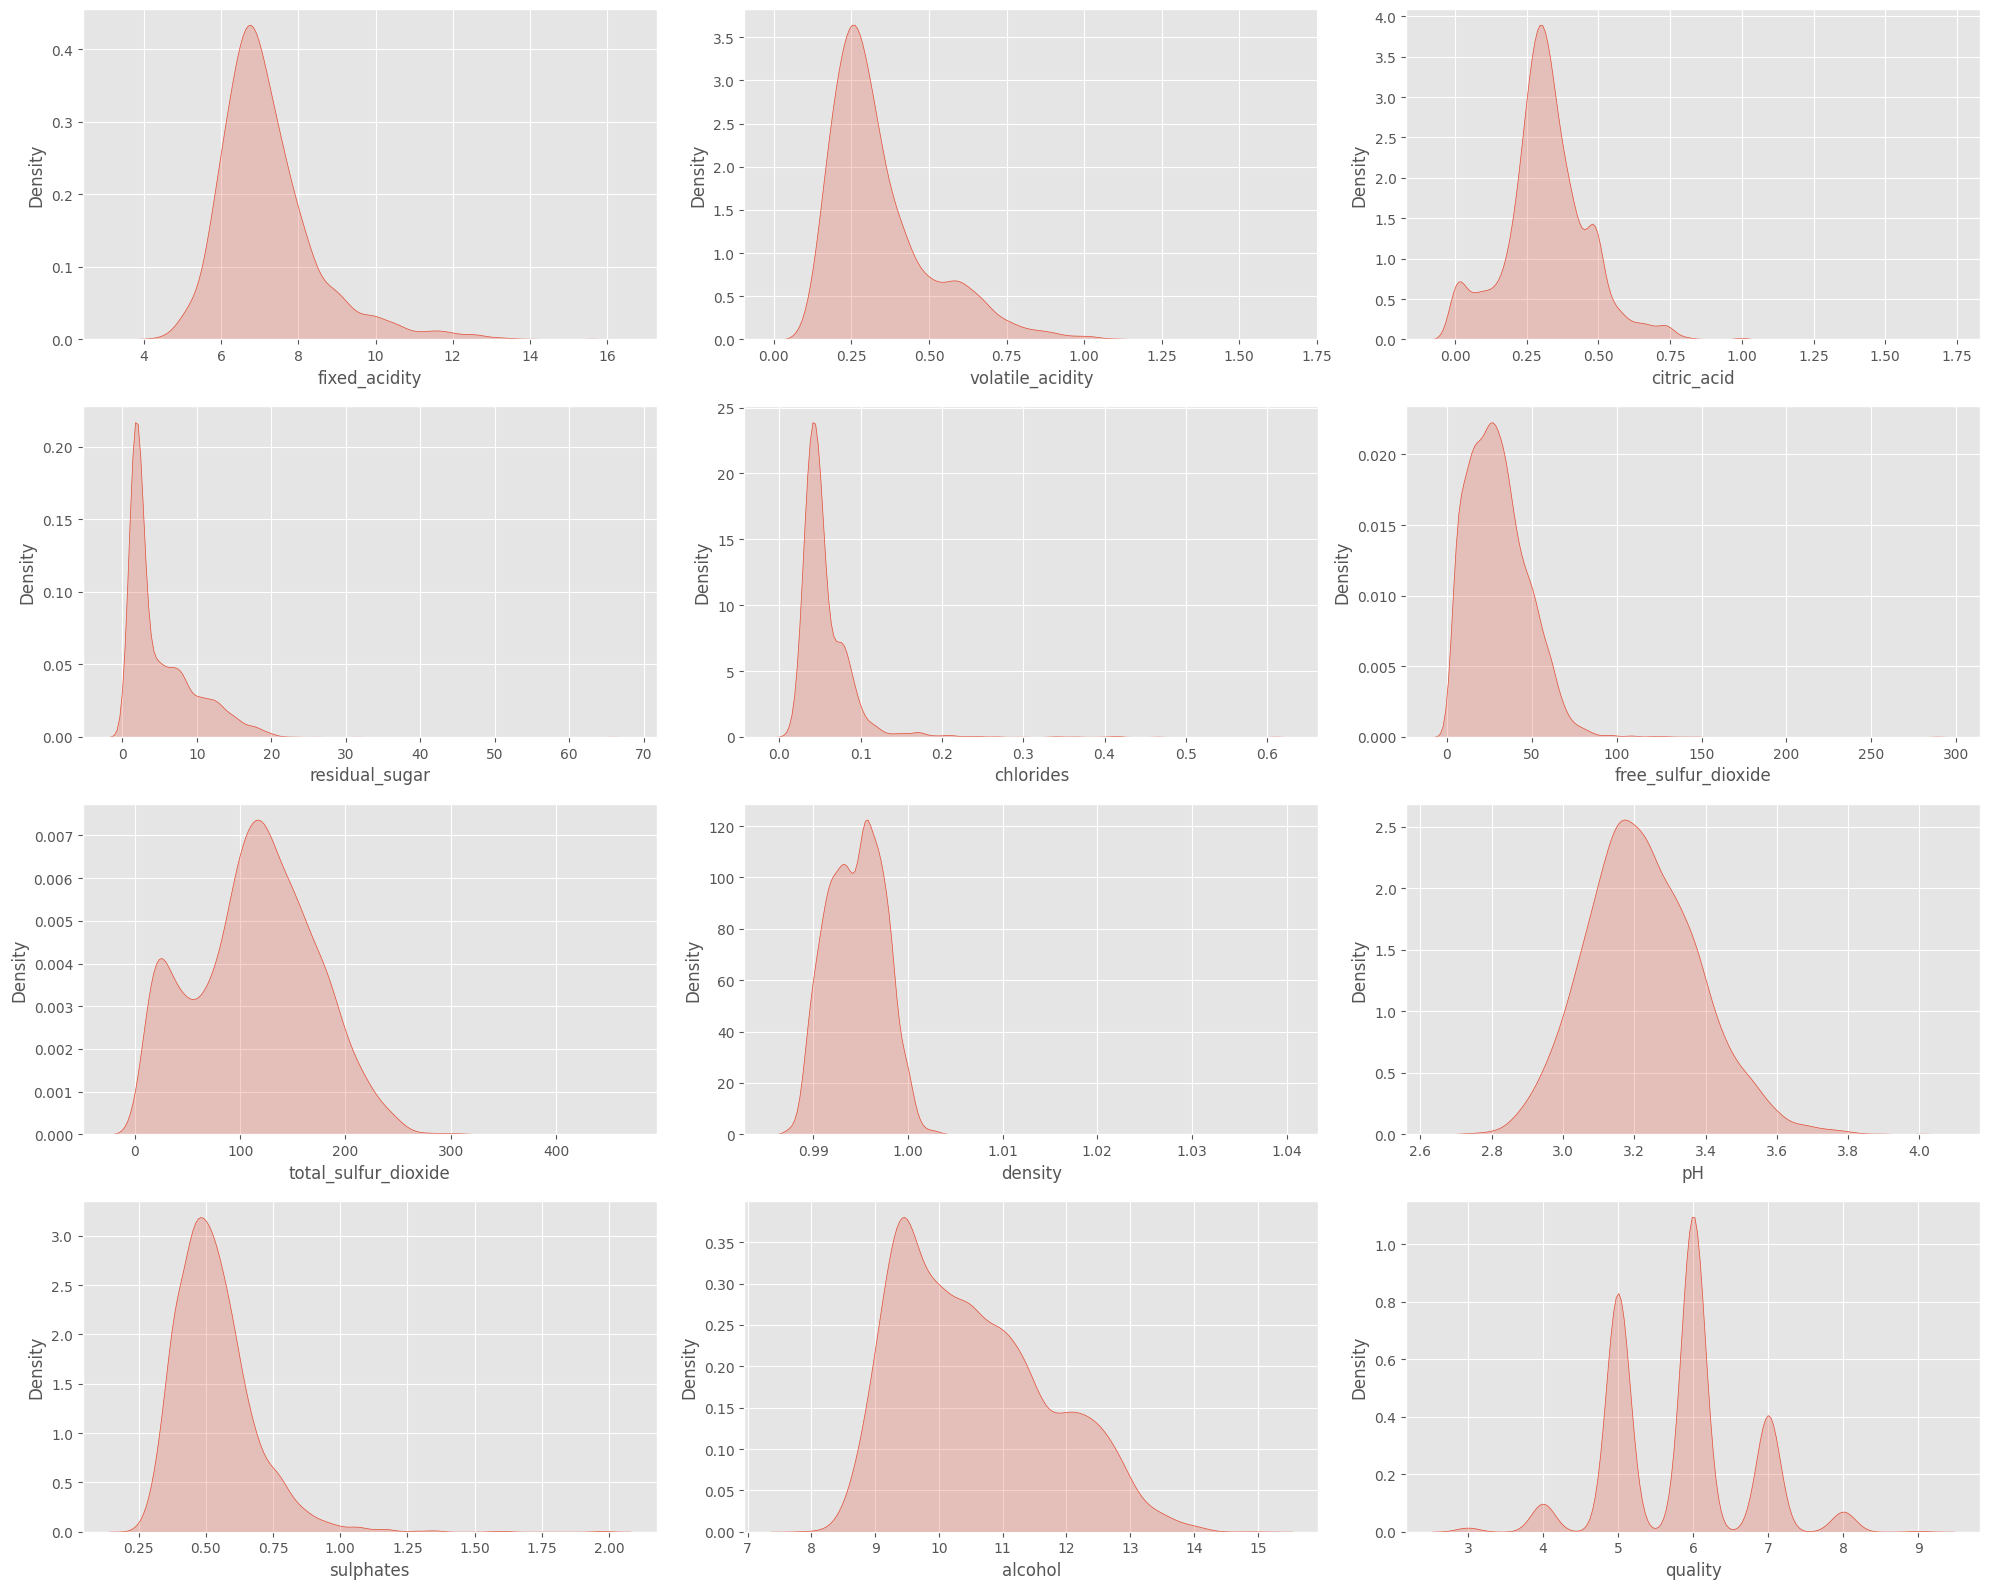

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.kdeplot(df[numeric_features[i]], fill=True, ax=ax)

These histograms tell me that the distribution of the data for all of the skewed to the left. This means that I will need to do some data transformation on the fields I decide to keep, so that the data is more normally distributed.

<hr />

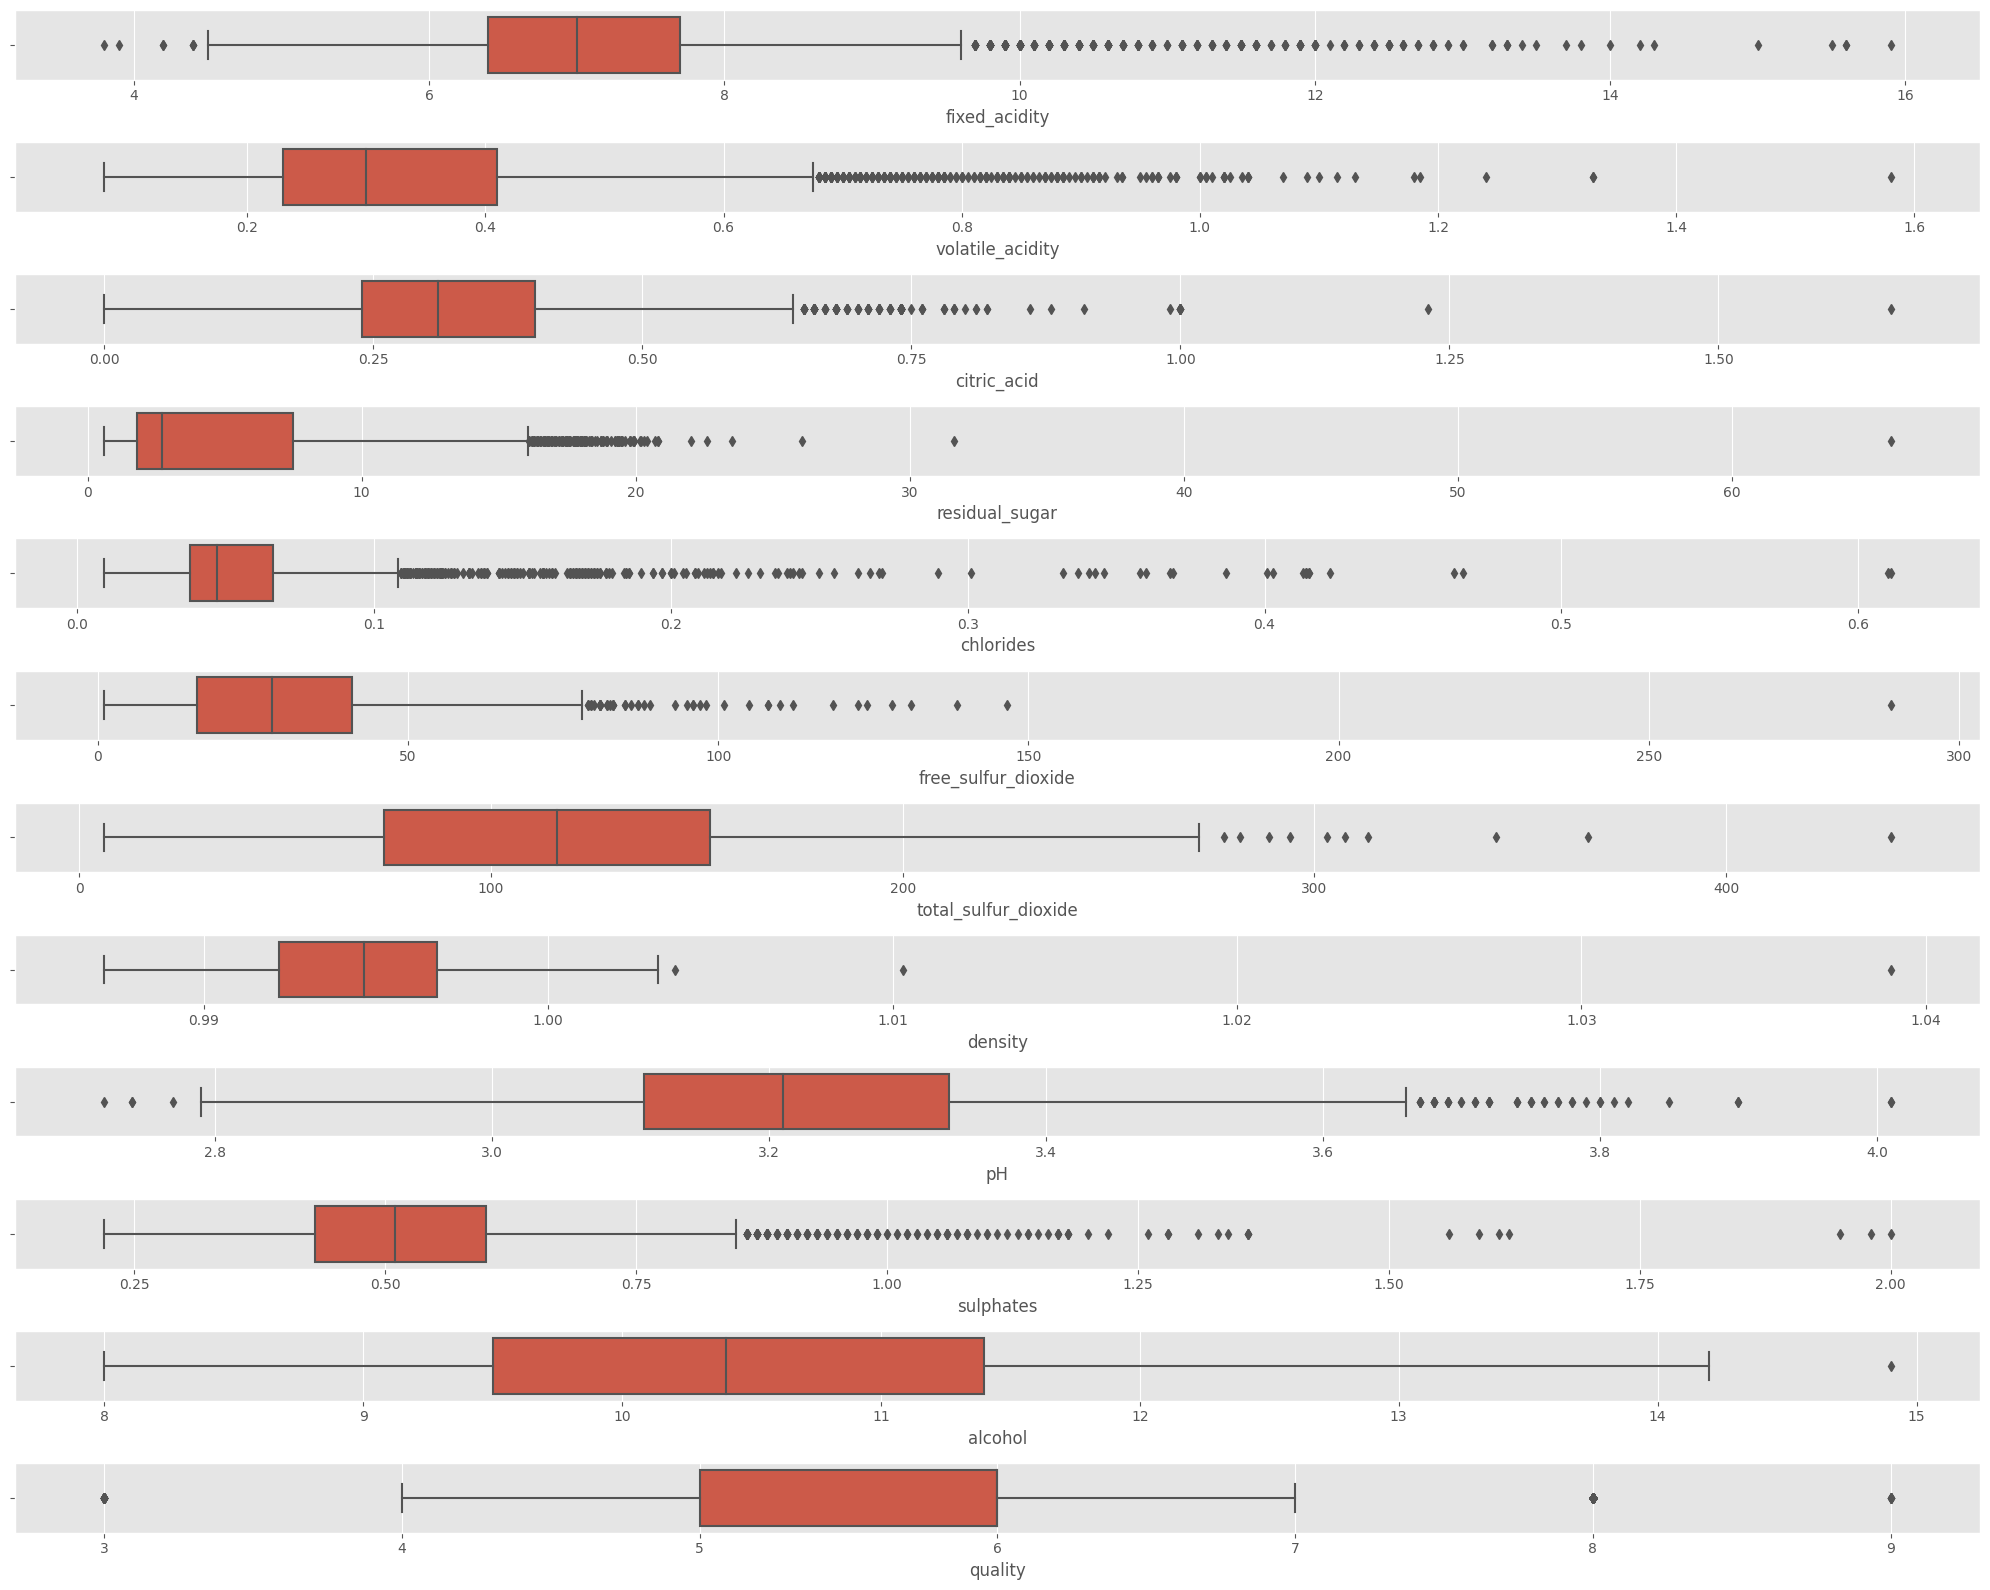

In [13]:
fig, axes = plt.subplots(12, 1, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.boxplot(x=df[numeric_features[i]], ax=ax)

These boxplots tell me that there are some outliers in the data. I will need to decide if I want to keep these outliers or not.

<hr />

## Handling Outliers

For each of the fields, I decided to do some trail and error to find out what percentile of the data (top and bottom percentile) I want to replace with the median value of the column, keeping the percentile value change to a minimum so as to not impute too many fields, but also to remove as many outliers as possible. Here are the outcomes of my trail and erroring

In [14]:
trim_config: dict[str, tuple[int, int]] = {
    "fixed_acidity": (0.03, 0.92),
    "volatile_acidity": (0, 0.81),
    "citric_acid": (0.06, 0.95),
    "residual_sugar": (0, 0.93),
    "chlorides": (0, 0.92),
    "free_sulfur_dioxide": (0, 0.9),
    "total_sulfur_dioxide": (0, 0.95),
    "density": (0, 0.99),
    "pH": (0.01, 0.98),
    "sulphates": (0, 0.96),
    "alcohol": (0, 0.99),
    "quality": (0.01, 0.97)
}

for feature, iqr_range in trim_config.items():
    df[f"{feature}_trimmed"] = df[feature].clip(
        df[feature].quantile(iqr_range[0]),
        df[feature].quantile(iqr_range[1])
    )

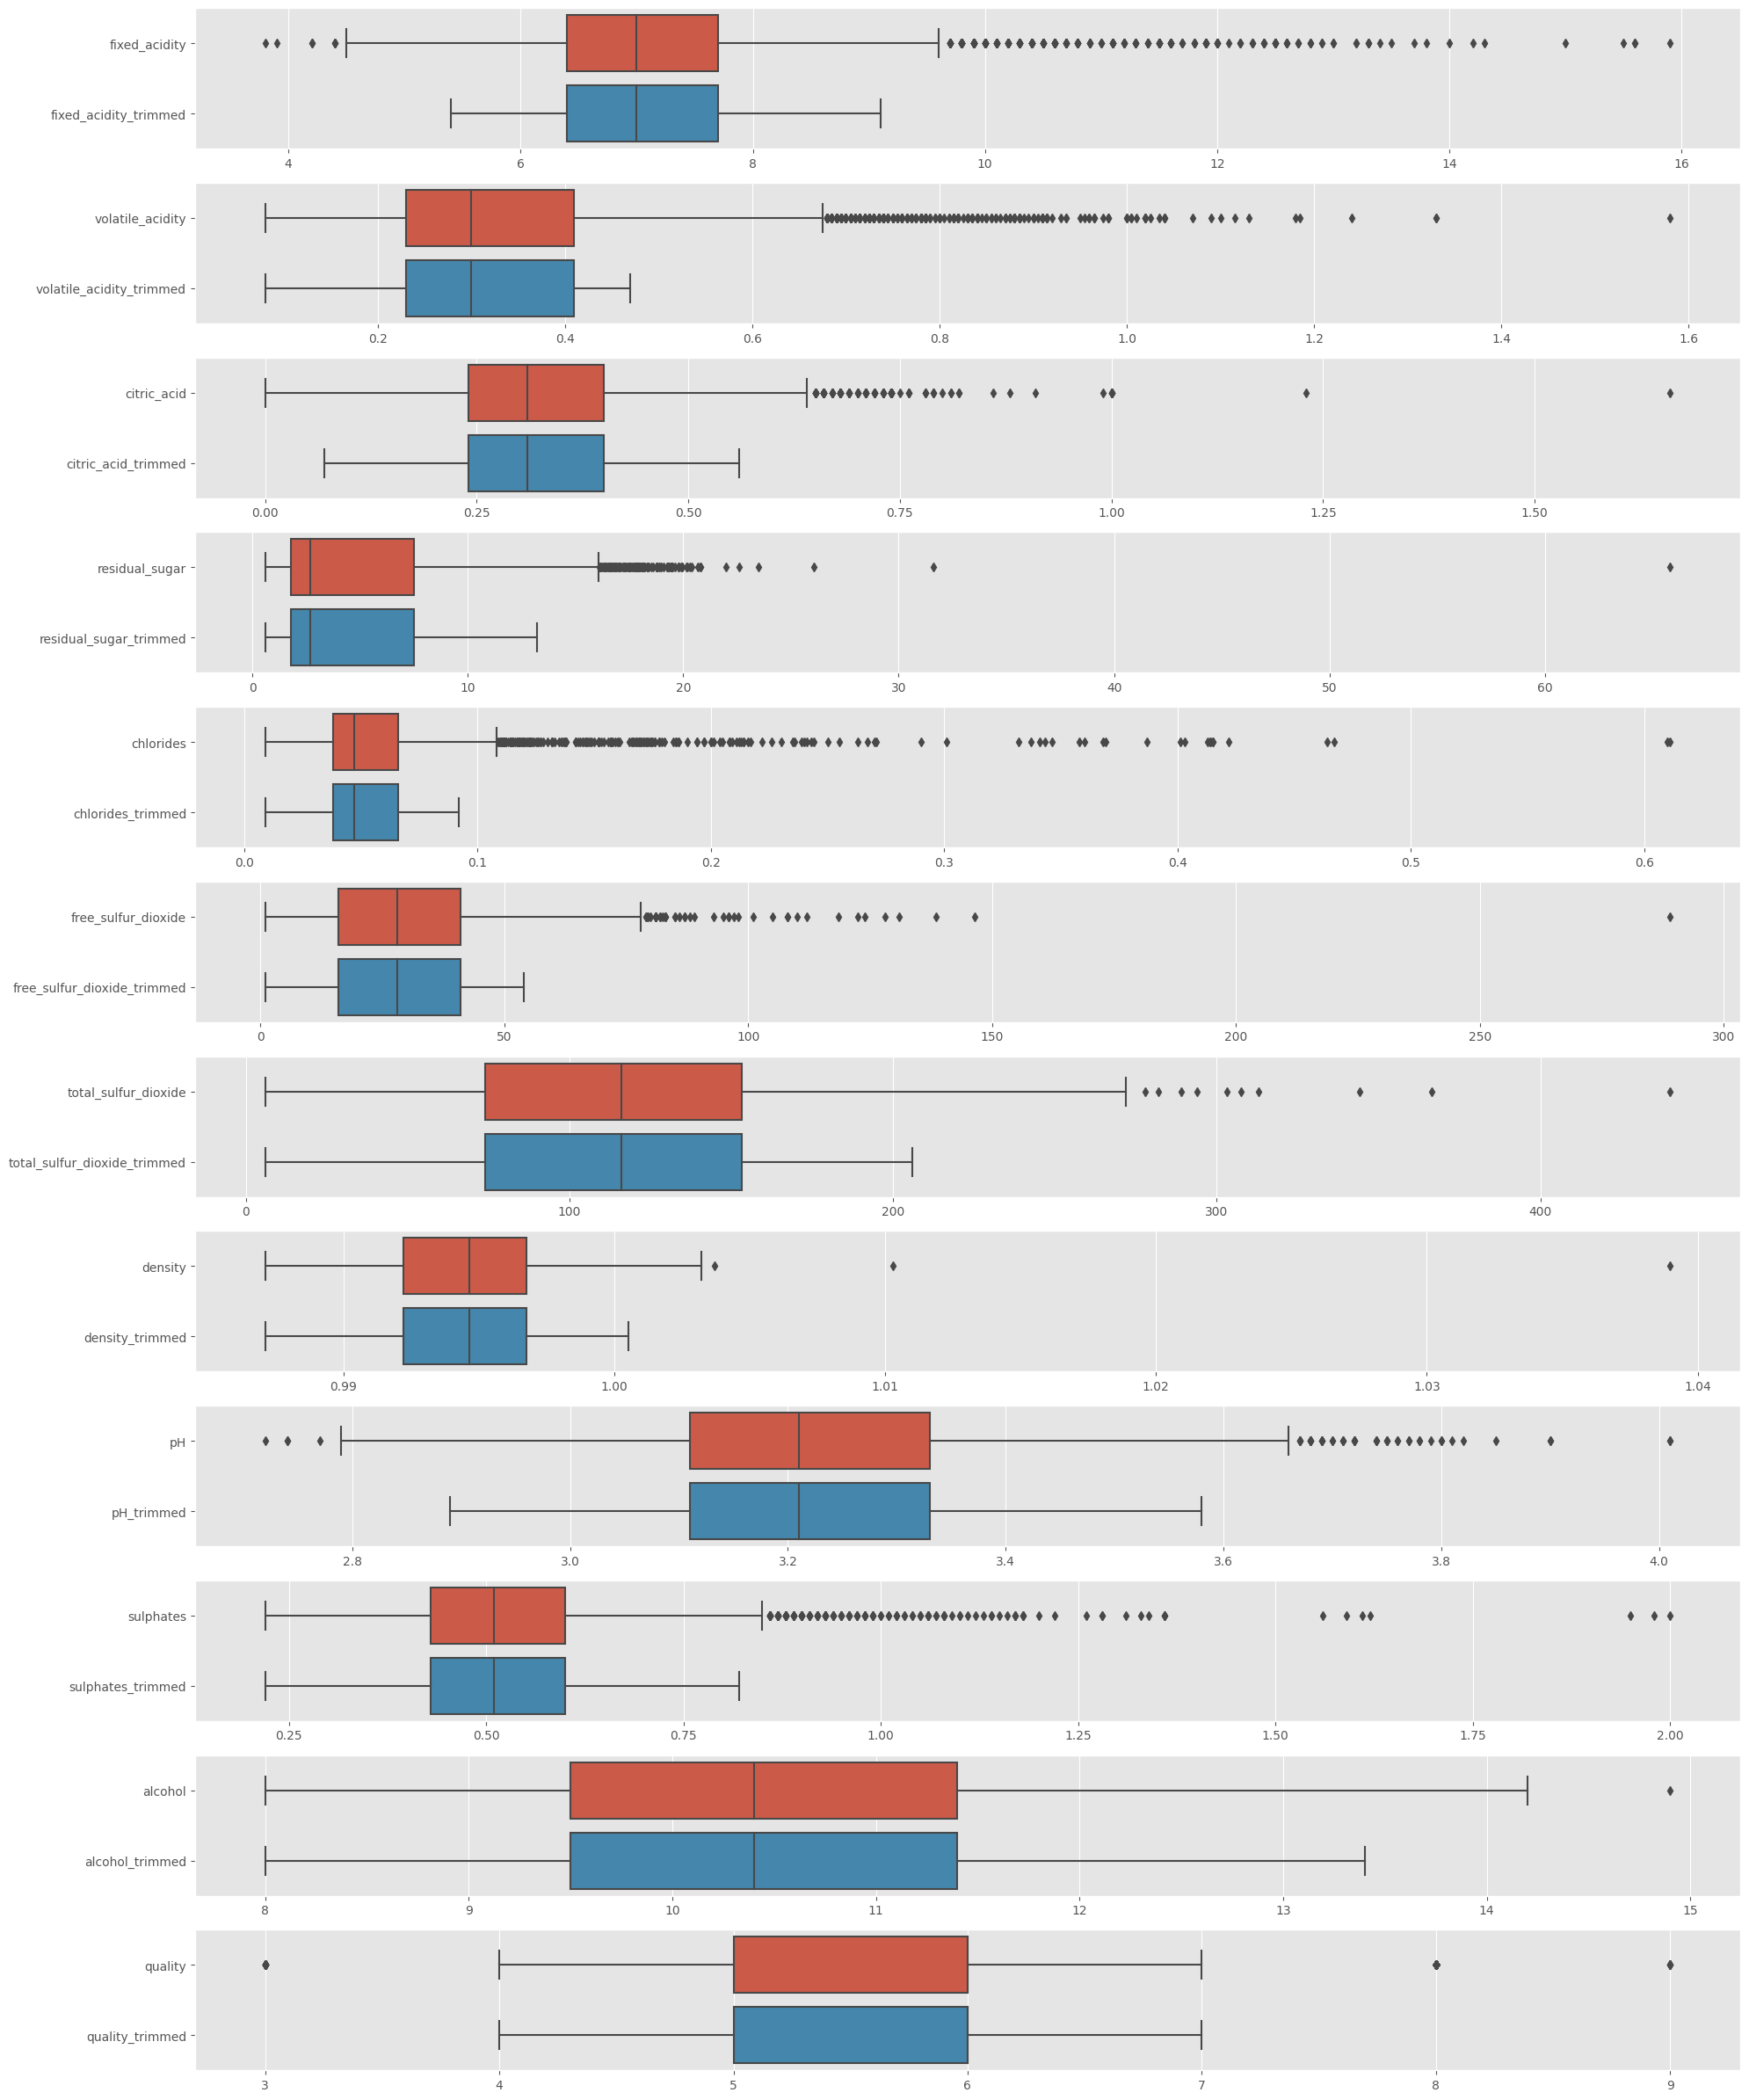

In [15]:
fig, axes = plt.subplots(12, 1, figsize=(20, 24), tight_layout=True)

for i, ax in enumerate(axes.flat):
    feature = numeric_features[i]
    sns.boxplot(
        pd.melt(df[[feature, f"{feature}_trimmed"]]),
        x="value",
        y="variable",
        ax=ax
    ).set(
        xlabel=None,
        ylabel=None
    )

### Overwriting the original columns with the trimmed columns

In [16]:
for feature in numeric_features:
    df[feature] = df[f"{feature}_trimmed"]
    df: pd.DataFrame = df.drop(columns=[f"{feature}_trimmed"])

## Correlation of each feature

<AxesSubplot: >

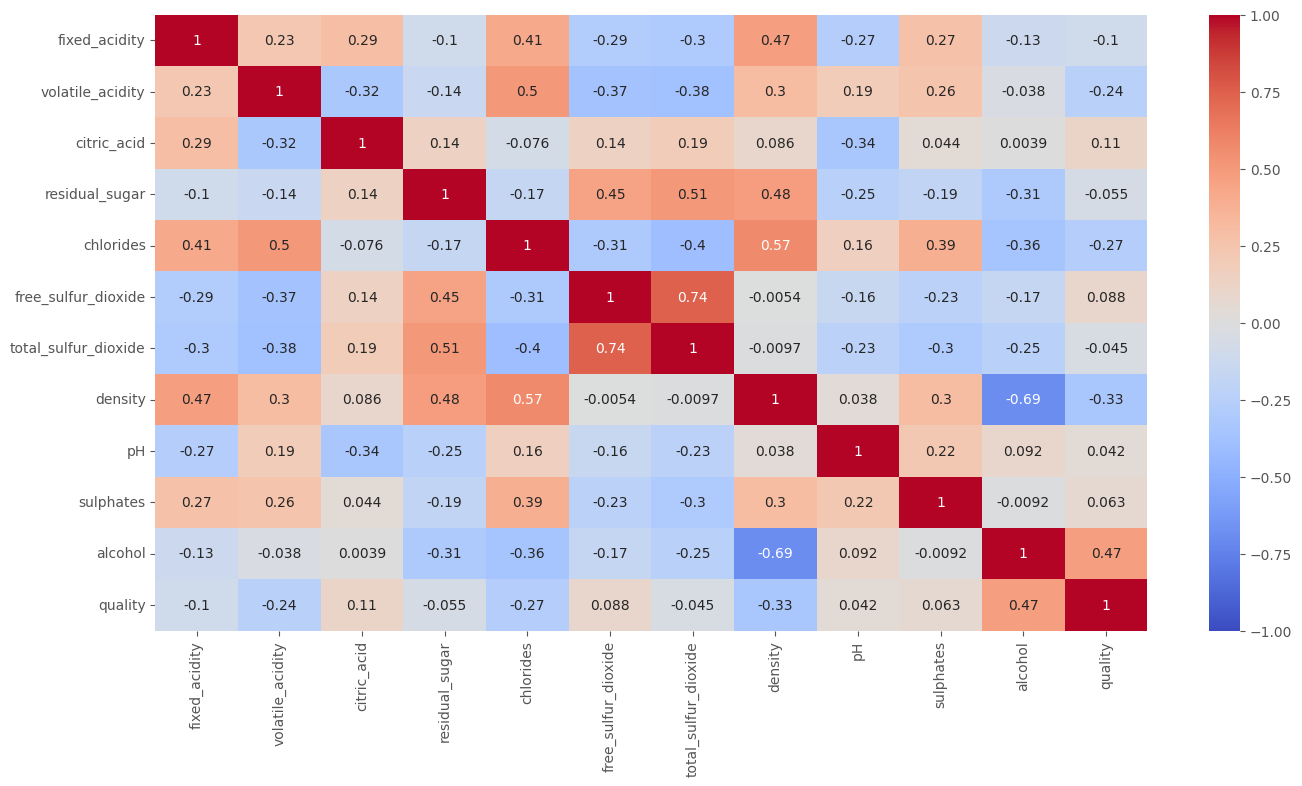

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(
    df[numeric_features].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax,
)

This correlation heatmap tells me that the features have a moderate correlation with each other. This means that I will need to do some feature selection to reduce the number of features I use in my model.

<hr />

## Correlation of each feature with the target

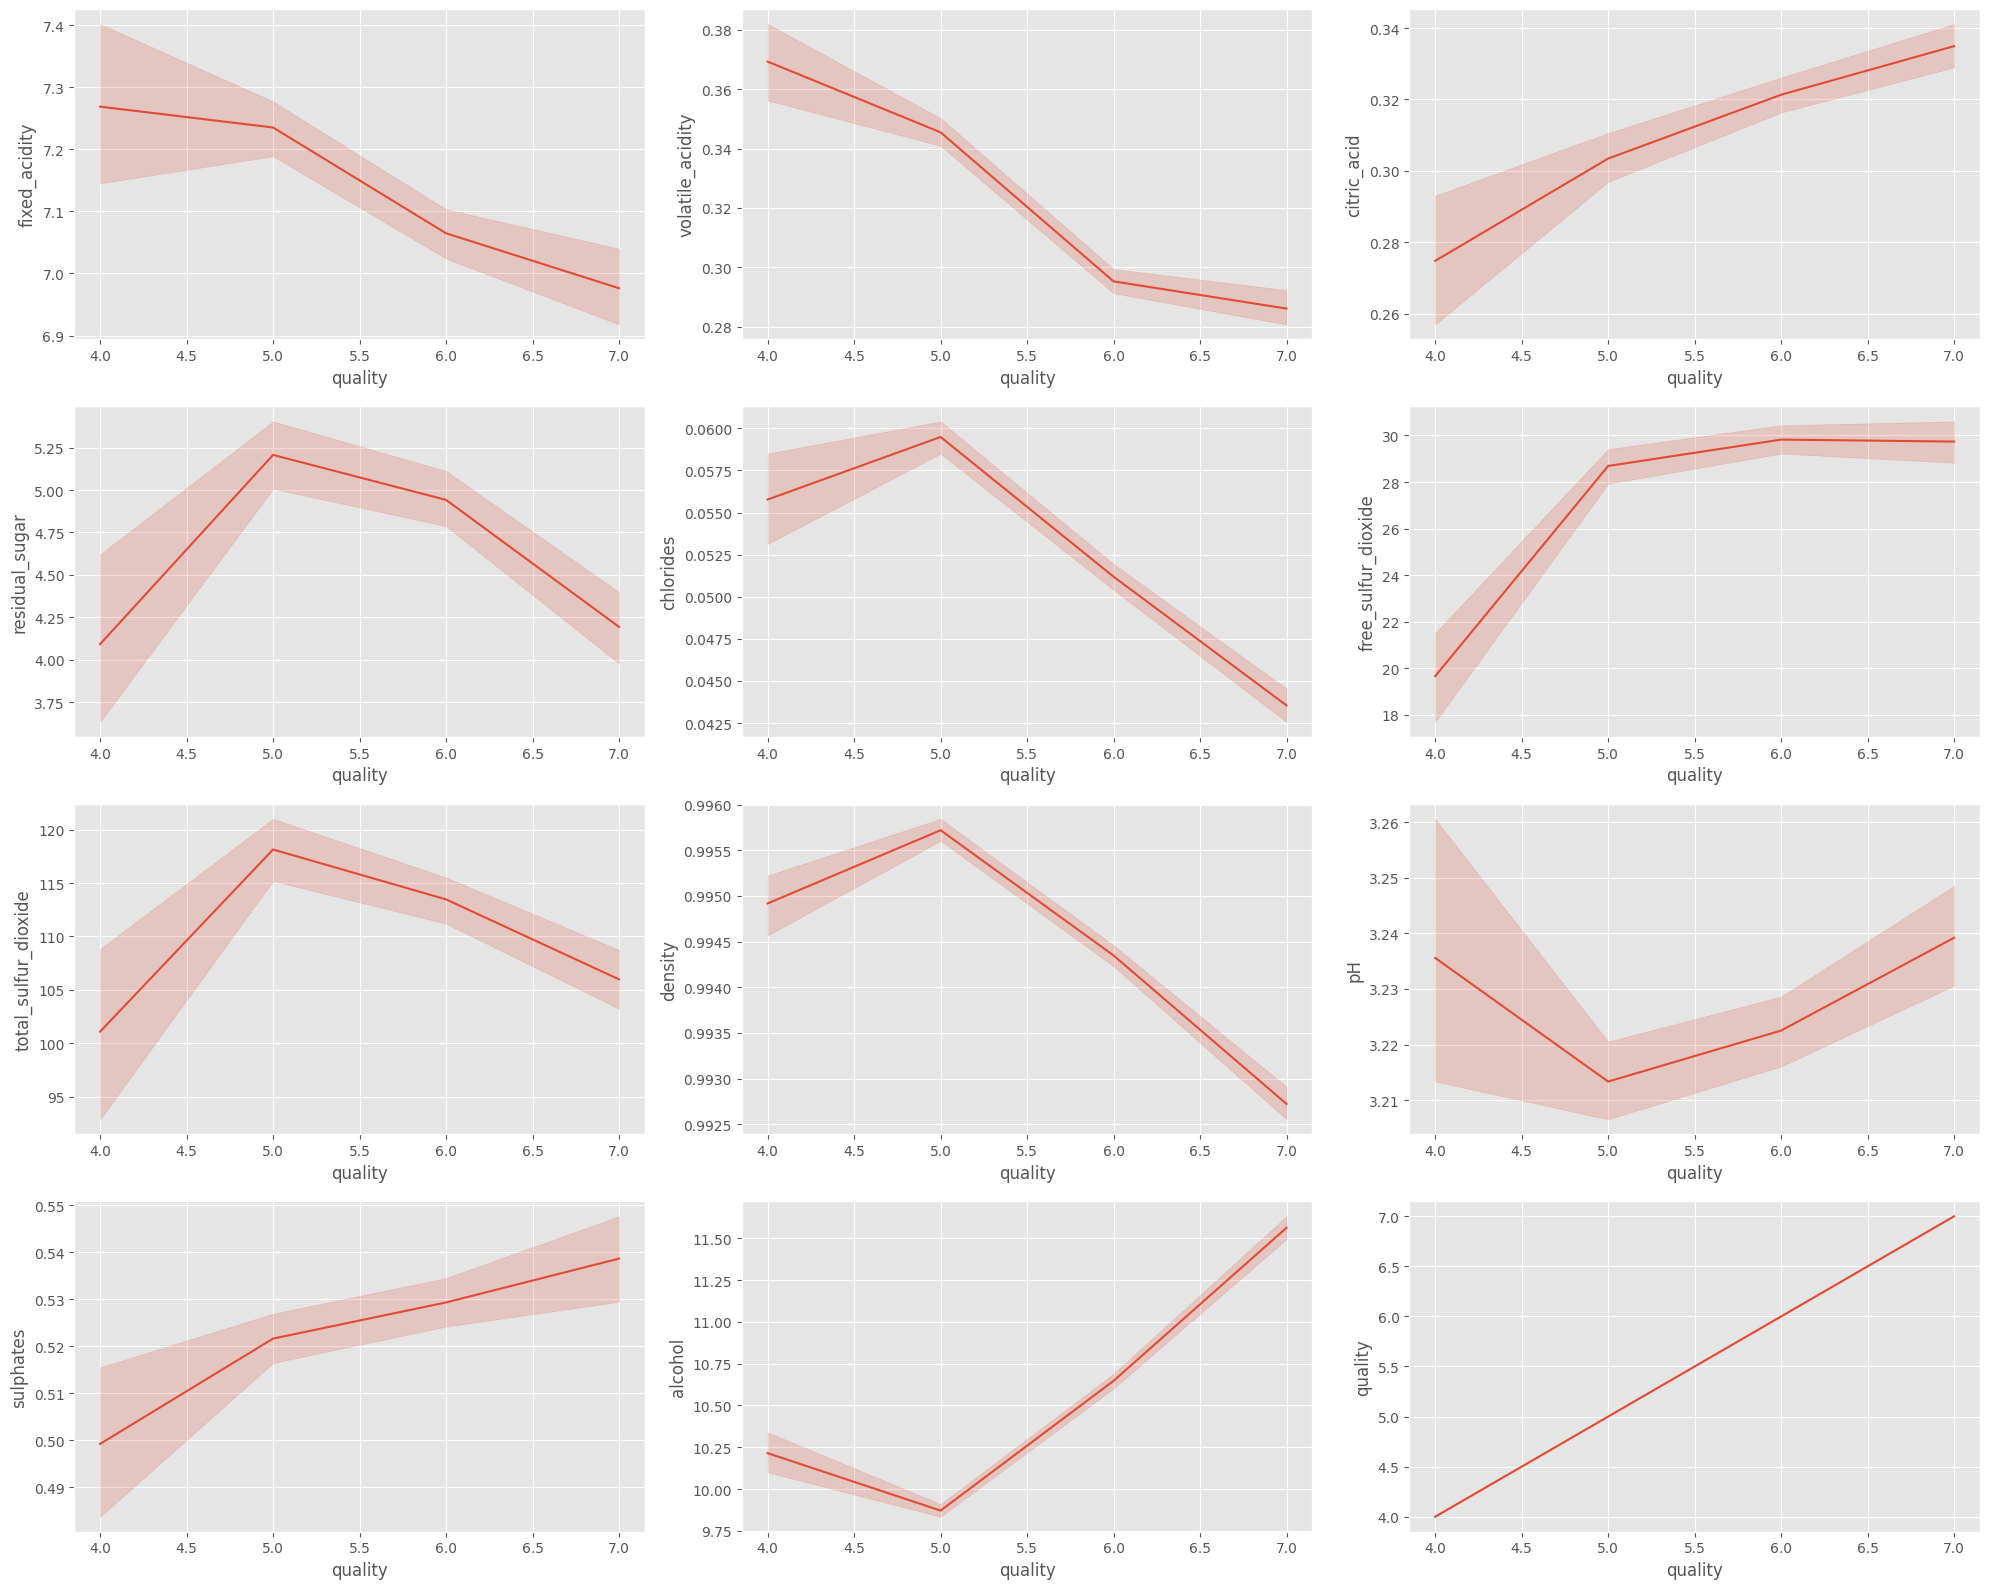

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.lineplot(df, x="quality", y=numeric_features[i], ax=ax)

These graphs tell me that some of the features are more likely to affect the quality of the wine than others since the lines are more linear than the others, and can be used to predict the quality of the wine better. 

<hr />

# Feature Engineering & Model Building

## Normally Distributing the Data

I decided to transform each column individually so that they aren't skewed to either direction

In [19]:
pd.DataFrame(
    [df[feature].skew() for feature in numeric_features],
    index=numeric_features,
    columns=["Skew"]
).T

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
Skew,0.478294,0.190691,-0.033395,0.956233,0.671164,0.158576,-0.163197,-0.027088,0.21155,0.531966,0.507905,-0.079722


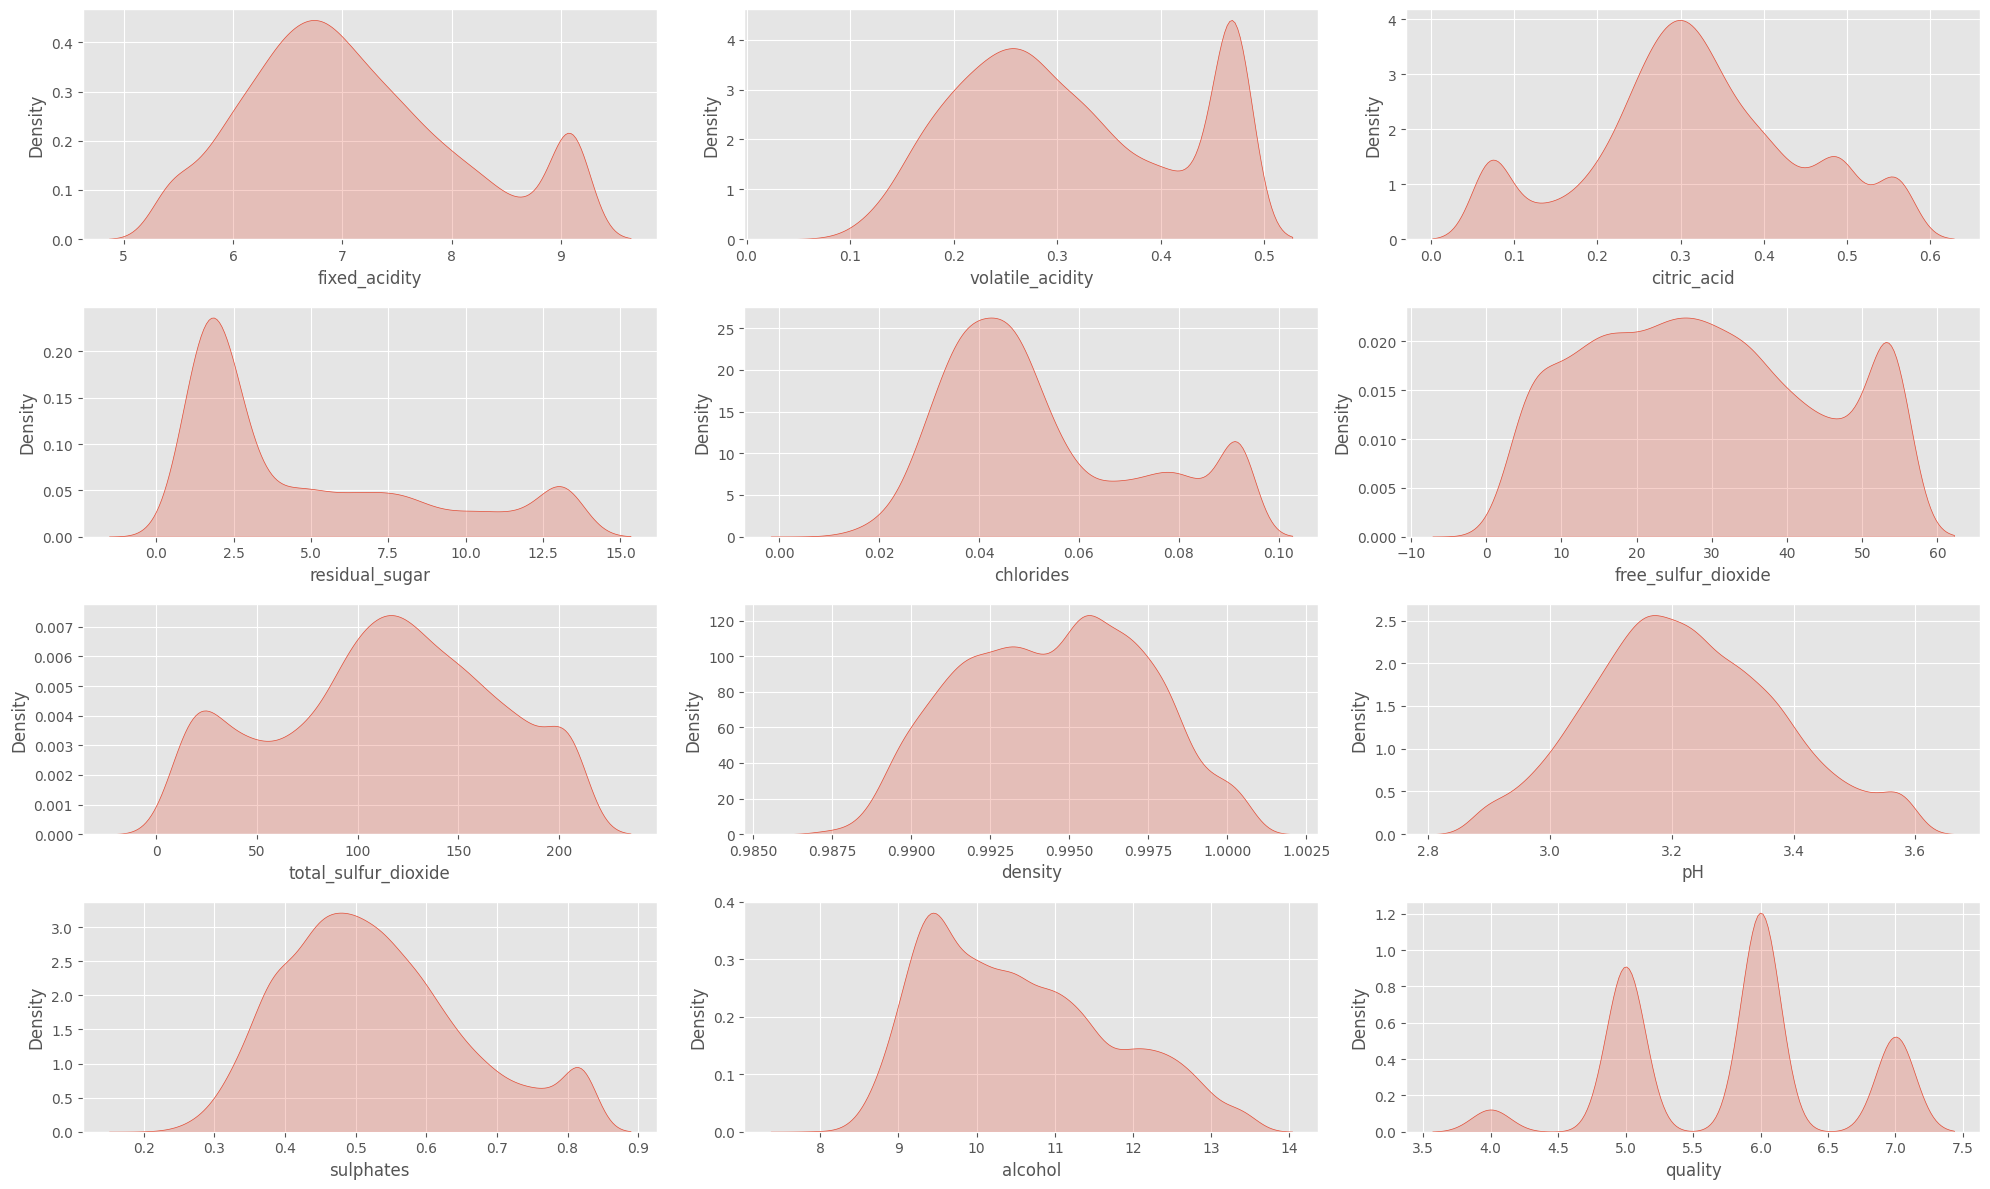

In [20]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.kdeplot(df[numeric_features[i]], fill=True, ax=ax)

In [21]:
for feature in numeric_features:
    df[f"{feature}_transformed"] = stats.boxcox(df[feature])[0]

In [22]:
pd.DataFrame(
    [[df[feature].skew(), df[f"{feature}_transformed"].skew()] for feature in numeric_features],
    index=numeric_features,
    columns=["Skew before transformation", "Skew after transformation"]
).T

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
Skew before transformation,0.478294,0.190691,-0.033395,0.956233,0.671164,0.158576,-0.163197,-0.027088,0.211550,0.531966,0.507905,-0.079722
Skew after transformation,0.020109,-0.056885,-0.089338,0.074382,-0.000167,-0.152743,-0.242567,-0.004400,0.005351,-0.000541,0.058510,-0.034401


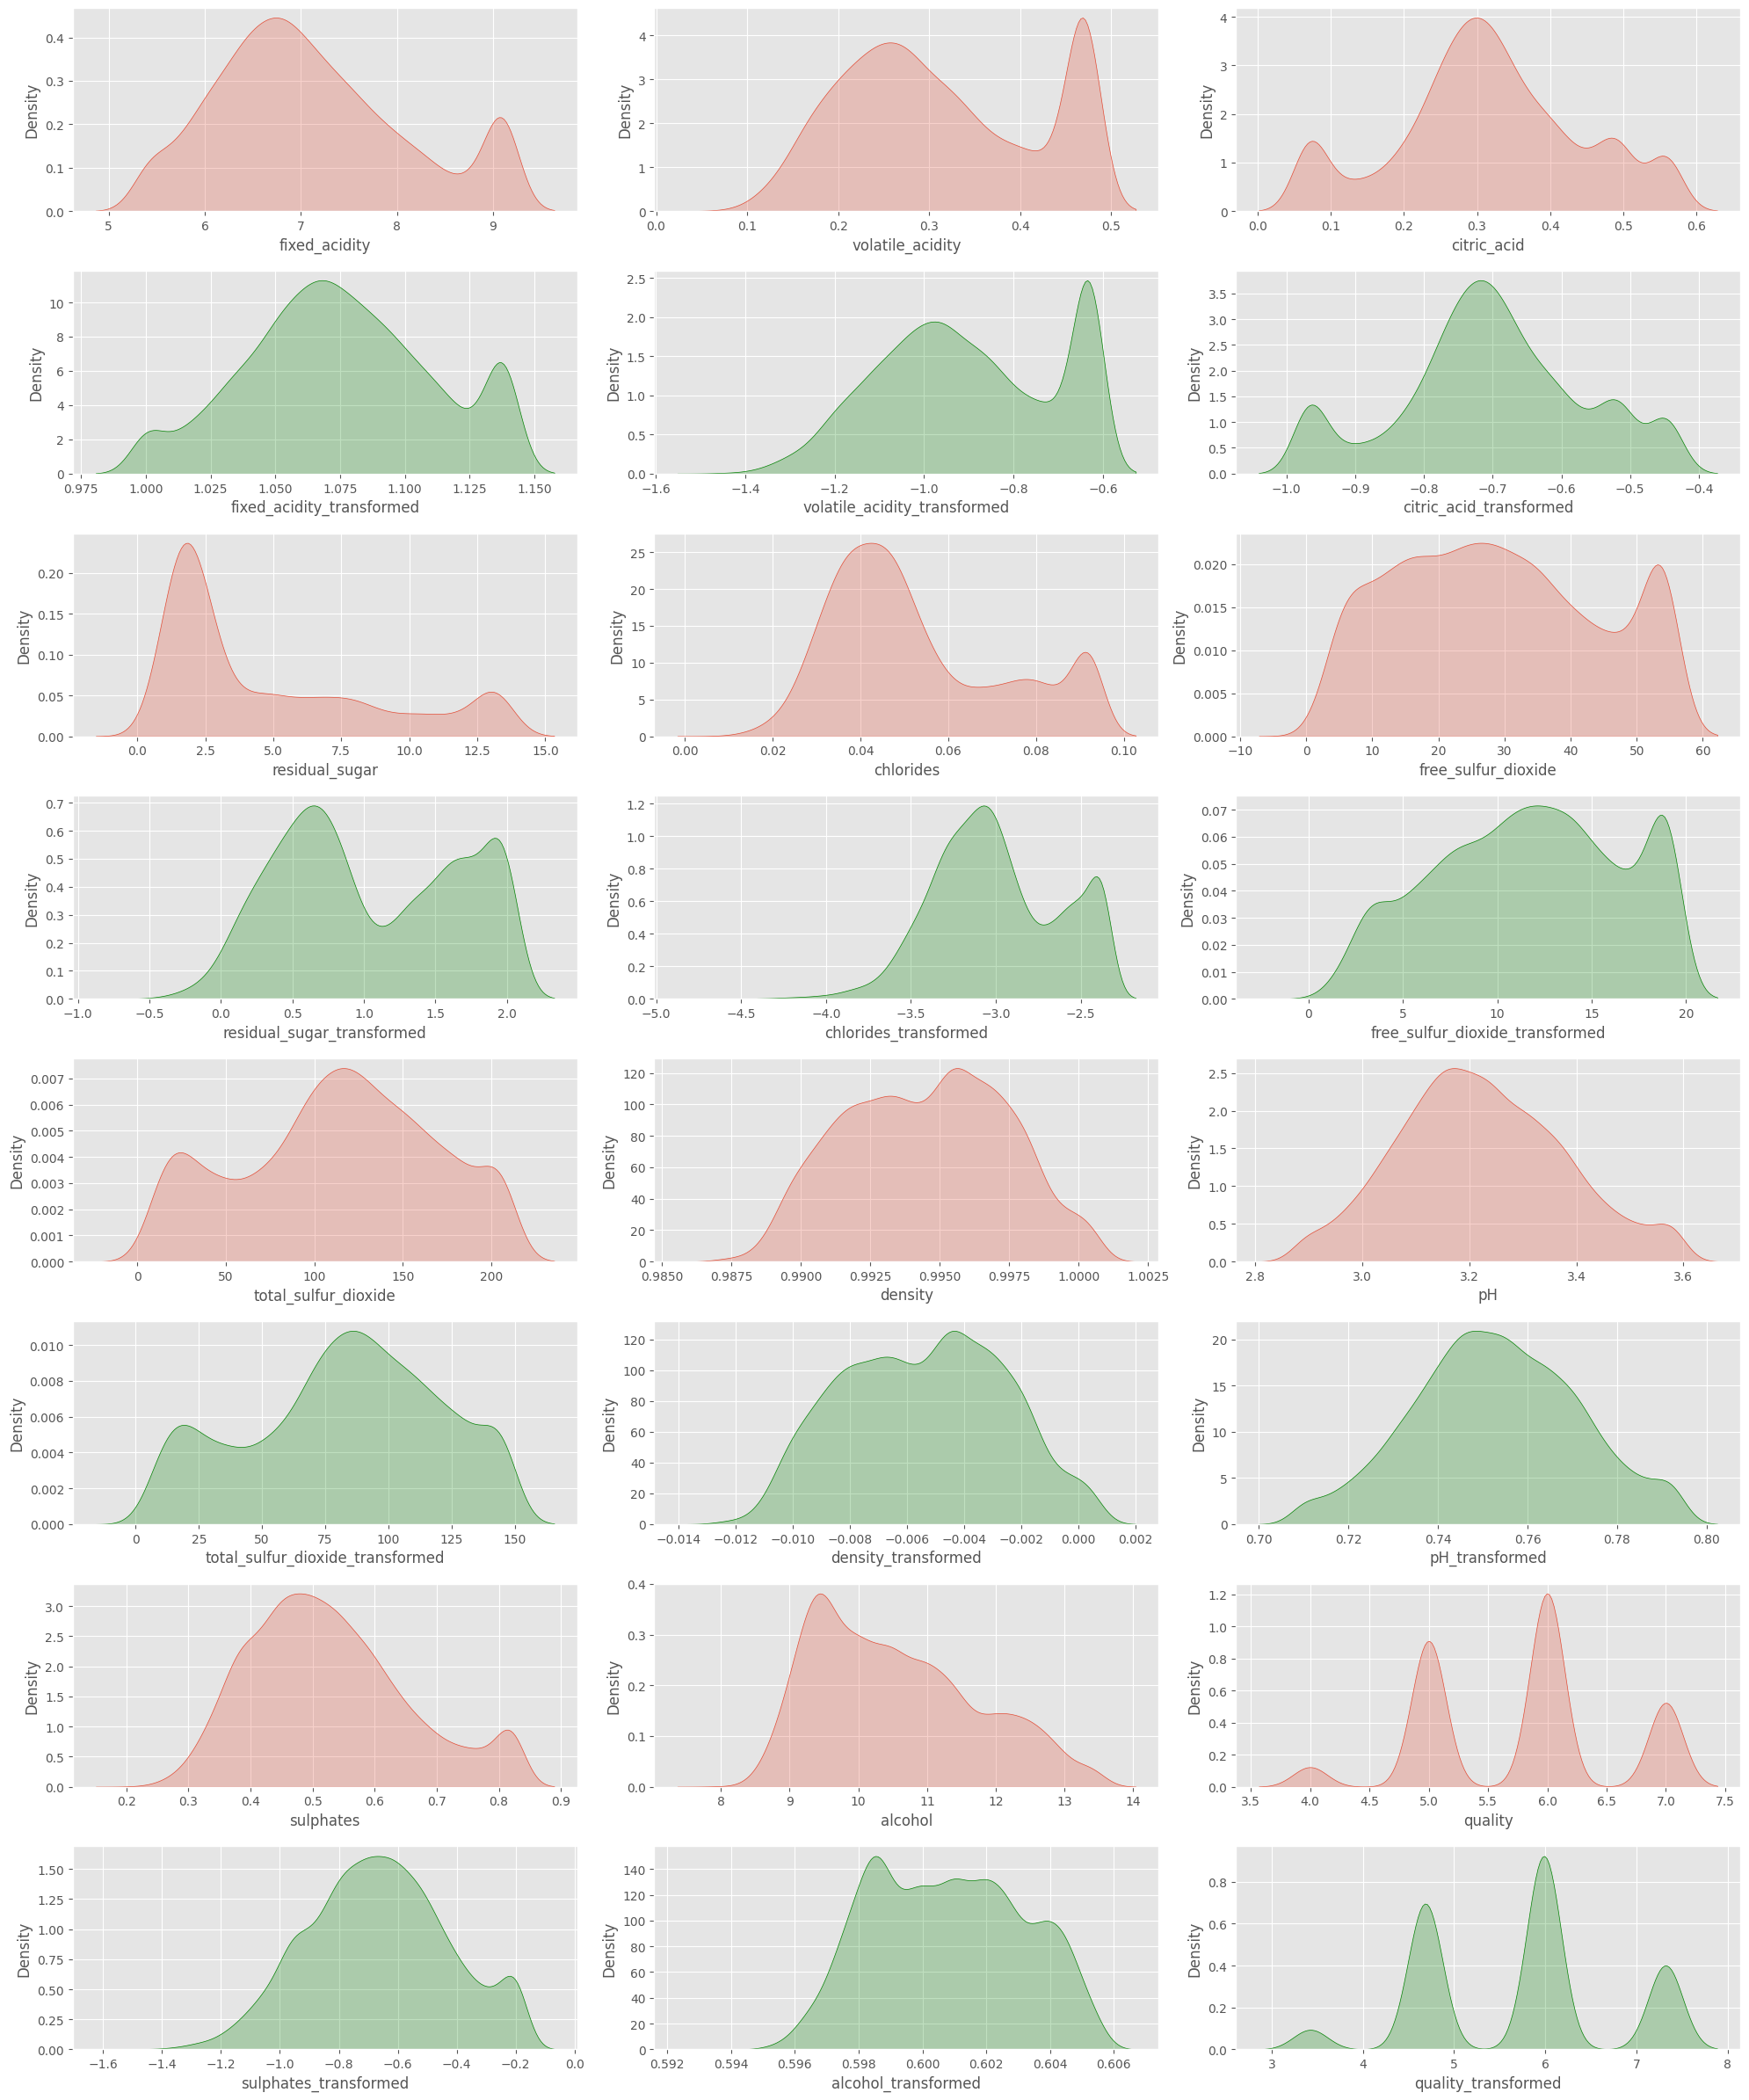

In [23]:
fig, axes = plt.subplots(8, 3, figsize=(20, 24), tight_layout=True)

for i, ax in enumerate(axes.flat):
    # some magic to get the right feature name
    feature = numeric_features[i - ((i % 6 > 2) + i // 6) * 3]
    if i % 6 > 2:
        sns.kdeplot(df[f"{feature}_transformed"], fill=True, color="green", ax=ax)
    else:
        sns.kdeplot(df[feature], fill=True, ax=ax)

### Overwriting the original columns with the transformed columns

In [24]:
for feature in numeric_features:
    df[feature] = df[f"{feature}_transformed"]
    df: pd.DataFrame = df.drop(columns=[f"{feature}_transformed"])

## Normalizing the data

I am using a pipeline with a standard scaler to normalize my numeric columns

In [25]:
numeric_pipeline = pipeline.Pipeline([
    ("scaler", preprocessing.MinMaxScaler())
])

## One Hot Encoding

I am using a pipeline with a one hot encoder to one hot encode the categorical features

In [26]:
categorical_pipeline = pipeline.Pipeline([
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="ignore"))
])

## Classifying the target

I decided to split the output into 3 classes, 1 for low quality, 1 for medium quality, and 1 for high quality. This is because my output variable is not exactly continuous (since the value is either 3, 4, 5, 6, 7, 8 or 9). However if I use regression to solve this, I will have to use a continuous output variable, so I decided to use classification instead.

<AxesSubplot: xlabel='quality', ylabel='Count'>

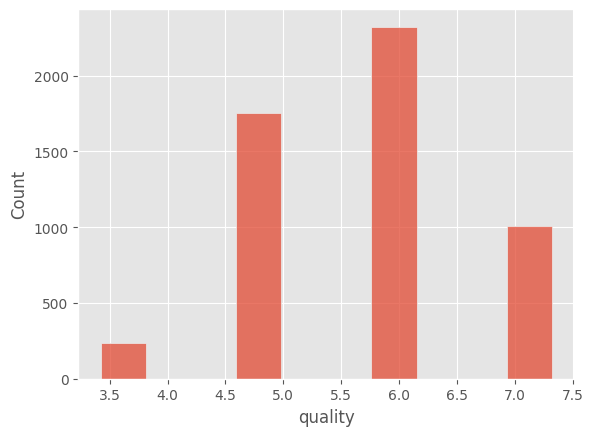

In [27]:
sns.histplot(df["quality"], bins=10)

From the above histogram we can roughly split the data into 3 classes, 1 for low quality, 1 for medium quality, and 1 for high quality. I will use this to classify the data.

In [28]:
df["quality_class"] = np.where(df["quality"] <= 4, "low", np.where(df["quality"] >= 7, "high", "medium"))

<AxesSubplot: xlabel='quality_class', ylabel='Count'>

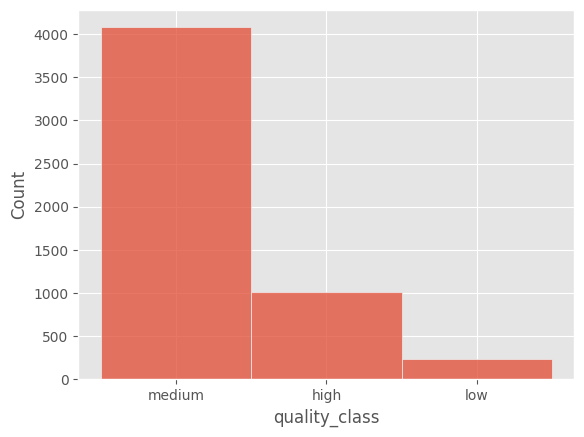

In [29]:
sns.histplot(df["quality_class"])

In [30]:
df = df.drop(columns=["quality"])

## First Draft of Model

I need to have at least one draft of the model before I can decide which features to keep, remove and scale for Feature Engineering. Becuase of this, I will run a simple RandomForestClassifier model with BayesSearchCV to find the best parameters for the model.

In [31]:
running_bayes = False

In [32]:
transformer = compose._column_transformer.ColumnTransformer([
    ("numeric", numeric_pipeline, df[[feature for feature in numeric_features if feature != "quality"]].columns),
    ("categorical", categorical_pipeline, df[categorial_features].columns)
])

rfc_pipeline = pipeline.Pipeline([
    ("preprocessor", transformer),
    ("classifier", ensemble.RandomForestClassifier(
        **({} if running_bayes else {"max_depth": 5697, "min_samples_leaf": 1, "min_samples_split": 3, "n_estimators": 665}),
        random_state=hash("2100326D") % 2 ** 32
    ))
])

In [33]:
X = df.drop(columns=["quality_class"])
y = df["quality_class"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7, random_state=hash("2100326D") % 2 ** 32)
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

Now depending on whether I've run BayesSearchCV, I will either load the best parameters found or calculate them again

In [34]:
if running_bayes:
    # Fix a bug in scikit-optimize
    np.int = int

    bs = searchcv.BayesSearchCV(
        rfc_pipeline,
        {
            "classifier__max_depth": (1, 10000),
            "classifier__min_samples_leaf": (1, 5),
            "classifier__min_samples_split": (2, 5),
            "classifier__n_estimators": (1, 1000)
        },
        n_iter=250,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    bs.fit(X_train, y_train)

    print("Best params:", bs.best_params_)
    print("Best score:", bs.best_score_)
    print("Train score:", bs.score(X_train, y_train))
    print("Test score:", bs.score(X_test, y_test))
else:
    rfc_pipeline.fit(X_train, y_train)

    print("Train score:", rfc_pipeline.score(X_train, y_train))
    print("Test score:", rfc_pipeline.score(X_test, y_test))

Train score: 0.9997313994090787
Test score: 0.7952410770194114


<AxesSubplot: >

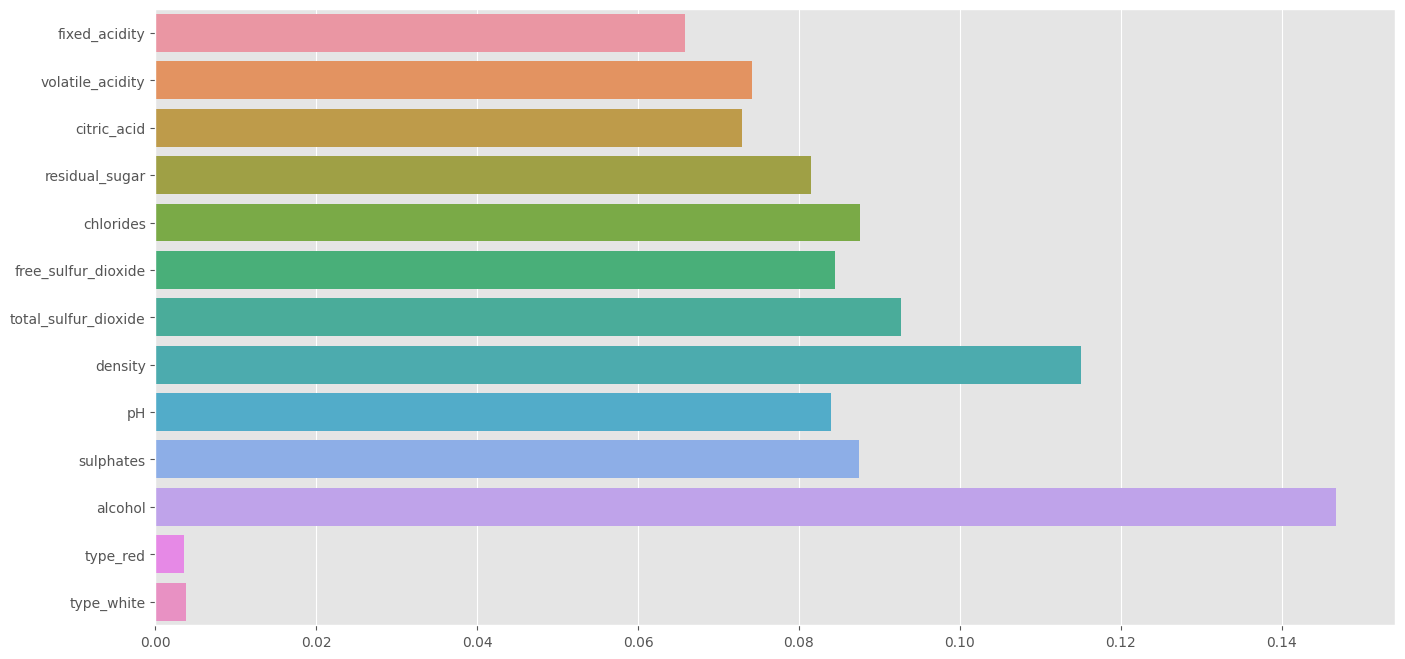

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))

rfc_pipeline: pipeline.Pipeline = bs.best_estimator_ if running_bayes else rfc_pipeline
_transformer: compose._column_transformer.ColumnTransformer = rfc_pipeline.steps[0][1]
_classifier: ensemble.RandomForestClassifier = rfc_pipeline.steps[1][1]
_categorical_pipeline: pipeline.Pipeline = _transformer.transformers_[1][1]
_onehot: preprocessing.OneHotEncoder = _categorical_pipeline.steps[0][1]

sns.barplot(
    x=_classifier.feature_importances_,
    y=list(X_train.drop(columns=["type"]).columns) + _onehot.get_feature_names_out().tolist(),
    ax=ax
)

## Feature Selection

## Feature Scaling

## Final Model